<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Submission" data-toc-modified-id="Submission-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Submission</a></span></li><li><span><a href="#Hypothesis" data-toc-modified-id="Hypothesis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Hypothesis</a></span></li><li><span><a href="#Entities-and-attributes" data-toc-modified-id="Entities-and-attributes-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Entities and attributes</a></span></li></ul></div>

# Pipeline design exercise

Welcome to Day 2 of DataJoint Workshop! In this session, you will work in a team to horn in your skills for pipeline design by designing and building a data pipeine to satisfy a real-life experimental project requirements!

# Task

Read the project scenario below carefully. You are given relevant entities for this experiment and attributes that you would want to keep track for each entity.

Your team's task is to design a data pipeline, complete with table definitions in DataJoint to hold all the entities for the project.

When you design your data pipeline, be sure to think about the following questions!
* What should be the data type for each attribute?
* Which attributes should be in the primary key?
* What's the dependency between the entities?
* What should be the tier of the table?
    * If `Imported` or `Computed`, what kind of processing should occur in `make`? (You don't have to implement it)


You might find the following data types list helpful when designing the table:

* `int` - holds integers like 152, 0, and -322
* `float` - holds numbers with decimal points like 3.123, 4.0, 1e-2, and -5.1111
* `varchar(N)` - holds string of up to N characters. i.e. `varchar(8)` can hold up to 8 characters string like `"applepie"` but not `"chocolate"`
* `ENUM("value1", "value2", ...)` - the field content must be one of the listed values. For example, if `ENUM("red", "blue", "green")`, the value must be `"red"`, `"blue"`, or `"green"`
* `date` - holds date value in the format of "YYYY-MM-DD". For example, `"2018-02-28"` and `"1988-11-19"`
* `datetime` - holds date and time in the format of "YYYY-MM-DD hh:mm:ss". For example, `"2018-02-01 15:32:10"` for year 2018, Feb 01 at 3:32pm 10 seconds.

## Submission

Have one person from your team submit a Jupyter notebook containing all the table class definitions into the `public` folder found at the top of the Jupyter Hub environment.

# Project scenario

The Gonzales lab is studying the behavior of different kinds of cells in two midbrain nuclei by slice physiology (patching) and subsequent morphological characterization of different cell types. Slices for patching are cut from juvenile or adult mice, and single or multiple intracellular membrane potential traces are recorded in a special bath media. Previous studies have shown that in some cells in these midbrain nuclei, this media elicits low tonic spontaneous activity and in other cells it cause vigorous phasic bursting. After patching is completed, the slices are fixed and images of each of the slices are collected. Patched cells are identified and manually segmented, and from this manual segmentation the size of the soma is computed. An automated algorithm processes all the ephys traces and classifies cells as “bursting” or “tonic”.

## Hypothesis

The hypothesis is that in juvenile mice,bursting cells and tonic cells in both nuclei A and B have different somatic sizes, but that in adult mice, somatic size is uniform across nuclei and cell types.

## Entities and attributes

Mouse
* Mouse ID
* Mouse Sex
* Mouse DOB

Slice
* Mouse ID
* Slice number
* Slice date
* Slice location (Anterior/Posterior)

PatchedCell
* Mouse ID
* Slice number
* Cell index
* Cell location (“Nucleus A”, “Nucleus B”, “Unknown”)
* Time elapsed between slicing and recording
* FIlename of recording

EphysTrace
* Mouse ID
* Slice number
* Cell index
* Recording index
* Trace length
* Trace scale 
* Raw Trace

SliceImage
* Mouse ID
* Slice number
* Image index
* Pixel dimensions
* Physical dimensions (microns)
* Image

SegmentedSoma
* Mouse ID
* Slice number
* Cell index
* Image index
* Segmentation mask
* Area of soma in microns^2

EphysType
* Mouse ID
* Slice number
* Cell index
* Ephys type (“Tonic”, “Bursting”, “Ambiguous”)

# Bonus

Can you come up with a query that you would use to fetch information you would need to test the hypothesis?

# My Solution

In [1]:
import datajoint as dj
dj.list_schemas()

Connecting houhan@tutorial-db.datajoint.io:3306


['houhan_pipeline_session3',
 'houhan_pipeline_session4',
 'houhan_tutorial',
 'houhan_tutorial_pipeline']

In [19]:
schema = dj.schema('houhan_pipeline_session4')

In [18]:
schema.drop()

Proceed to delete entire schema `houhan_pipeline_session4`? [yes, No]: yes


In [20]:
@schema
class Mouse(dj.Manual):
    definition = """
    mouse_id: int  # Mouse ID
    ---
    sex="unknown": ENUM('F', 'M', 'unknown')  # Sex
    dob: date # Birthday    
    """
    
@schema    
class Slice(dj.Manual):
    definition = """
    -> Mouse
    slice_num: int # Slice Number
    ---
    slice_date: date # Slice date
    slice_loc: ENUM('Anterior', 'Posterior')  # Slice location
    """
    
@schema
class PatchedCell(dj.Manual):
    definition = """
    -> Slice
    cell_idx: int # Cell index
    ---
    cell_loc: ENUM('Nucleus A', 'Nucleus B', 'Unknown')
    time_lapsed: int   # In minute
    filename: varchar(30)  # Filename    
    """

@schema
class EphysTrace(dj.Imported):
    definition = """
    -> PatchedCell
    recording_idx: int  # Recording index
    ---
    trace_len: int  # Trace length
    trace_scale: float 
    raw_trace: longblob    
    """
    def make(self, key):
        pass

@schema
class SliceImage(dj.Imported):
    definition = """
    -> Slice
    image_idx: int
    ---
    pxl_width : int # pixel width of image
    pxl_height : int # pixel height of image
    um_width : float # width field of view in microns
    um_height : float # height field of view in microns
    image: longblob   # Raw image   
    """
    def make(self, key):
        pass

@schema
class SegmentedSoma(dj.Computed):
    definition = """
    -> PatchedCell  
    -> SliceImage   # Note this!!!
    ---
    segment_mask: longblob
    area_of_soma: float   # In micron    
    """
    def make(self, key):   # Even this table involves "real manual" processing, still "Computed" because we need "make"!!
        pass
    
@schema
class EphysType(dj.Computed):
    definition = """
    -> PatchedCell
    ---
    ephys_type: ENUM('Tonic', 'Bursting', 'Ambiguous')
    """
    def make(self, key):
        pass

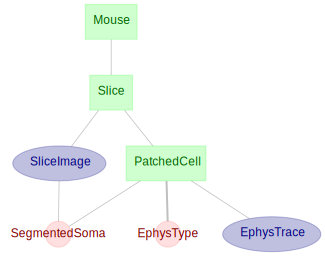

In [21]:
dj.ERD(schema)

In [26]:
target = PatchedCell * Mouse * Slice * EphysType * SegmentedSoma & \
         'ephys_type in ("tonic", "burst") and cell_loc in ("A", "B")'

selected = target.proj('ephys_type', 'cell_loc', 'area_of_soma', age='DATEDIFF(slice_date, dob)')
ephys_type, area, size, age = selected.fetch('ephys_type', 'cell_loc', 'area_of_soma', 'age')